In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression

import os

# Regression Models

#### Работа с голям обем данни

Най-често подхода е разделяме големия файл на малки парчета. На всяко едно парче правин мякаква обработка - получаваме друго парче. И всяка една от тези части много често агрегираме по някакъв начин, много често по един запис или по няколко свързани такива. Този процес се нарича map-reduce.

tensorflow: Dataset - batch, map

1. Имаме един списък - например с 5 пътечки към имиджи вътре и това за разлика от изображенията е нещо, което се събира в паметта, това са стрингове).
2. Прочитаме ги (read them).
3. process them
4. pass them through the model
5. result = ["cat", "tiger", ...]

Един модел, на който му се подава данни не се интересува колко данни ще получи, единствено ако е един, трябва да му подадем не един запис, едно изображение, ами списък от едно изображение. 
Това цялото нещо е начин за работа с данни, който е по-разумен и който ни позволява да сме много гъвкави.
Ако си представим, че все един от тези редове е по една или по няколко функции, чийто резултати се предават една на друга можем да видим, че това е композиция от функции. Бихме я нарекли data pipeline.

Ако използваме pytorch, той също има Dataset като има Dataset и DataLoader. Dataset ни оказва самите данни какви са и какво представляват, а DataLoader е по какъв начин да бъдат обработени-зареждани, разбърквани и т.н. В tensorflow това се прави наведнъж.

In [2]:
os.listdir("../04. Working with Images/cat_taxonomy")

['african-wildcat',
 'blackfoot-cat',
 'chinese-mountain-cat',
 'domestic-cat',
 'european-wildcat',
 'jungle-cat',
 'sand-cat']

In [3]:
os.walk("../04. Working with Images/cat_taxonomy")

<generator object _walk at 0x00000187D8131A20>

In [4]:
list(os.walk("../04. Working with Images/cat_taxonomy"))

[('../04. Working with Images/cat_taxonomy',
  ['african-wildcat',
   'blackfoot-cat',
   'chinese-mountain-cat',
   'domestic-cat',
   'european-wildcat',
   'jungle-cat',
   'sand-cat'],
  []),
 ('../04. Working with Images/cat_taxonomy\\african-wildcat',
  [],
  ['af (1).jpg',
   'af (10).jpg',
   'af (11).jpg',
   'af (12).jpg',
   'af (13).jpg',
   'af (14).jpg',
   'af (15).jpg',
   'af (16).jpg',
   'af (17).jpg',
   'af (18).jpg',
   'af (19).jpg',
   'af (2).jpg',
   'af (20).jpg',
   'af (21).jpg',
   'af (22).jpg',
   'af (23).jpg',
   'af (24).jpg',
   'af (25).jpg',
   'af (26).jpg',
   'af (27).jpg',
   'af (28).jpg',
   'af (29).jpg',
   'af (3).jpg',
   'af (30).jpg',
   'af (31).jpg',
   'af (32).jpg',
   'af (33).jpg',
   'af (34).jpg',
   'af (35).jpg',
   'af (36).jpg',
   'af (37).jpg',
   'af (38).jpg',
   'af (39).jpg',
   'af (4).jpg',
   'af (40).jpg',
   'af (41).jpg',
   'af (42).jpg',
   'af (43).jpg',
   'af (44).jpg',
   'af (45).jpg',
   'af (46).jpg',
  

In [5]:
dir_name, dir_names, file_names = list(os.walk("../04. Working with Images/cat_taxonomy"))[1]

In [6]:
file_names[:5]

['af (1).jpg', 'af (10).jpg', 'af (11).jpg', 'af (12).jpg', 'af (13).jpg']

Много често когато работим с данни те са големи. Когато ще работим с невронни мрежи ще имаме голям проблем, защото ще трябва в паметта на GPU-то, на графични процесор), да съберем целия модел + данните, които му трябват в момента. Паметта на GPU-то е скъпа и много ценна, трябва да я пазим. Имаме интерес модела да заема възможно най-голяма част от нея и да оставим минимално място за други неща - възможно по-малко. Но това означава, че не можем да заредим целия dataset. Вероятно и на много голяма машина не можем да го заредим целия, дори да нямаше това ограничение.

Сега ще видим как Data Science, работа с data pipelines, автоматизация, възпроизведимост как се съчетават с моделирането. защото окей, имаме данни - почистени, подредени - какво ще ги правим? Основното нещо, което да ги направим е да направим ментален модел на тези данни. Това върши работа. Това означава експертен анализ. Ние сме хората, които ги анализираме. Това се прави, ама е много остаряло. Експертни модели още има.
Обаче, ако имаме много данни можем да подходим по друг начин. Можем да намерим функция, която ги описва добре и тази функция да я напишем математически, после да я прилагаме. Тази функция винаги допуска грешка. Няма нито един модел, който да е перфектен. То затовюа това е модел - не е реалността, а някакво приближение на реалността.

Ще се опитаме да вземем от данните полезна информация, да игнорираме шума и да получим функция която апроксимира добре данните, т.е. като й подадем подходящия вход, ще получим изход, който е много правдоподобен.

#### Задача
Имаме много на брой данни като искаме да получим нещо полезно за тях. Само че тези данни не са дошли от нищото, някакъв процес ги е генерирал. И този процес, който ги е генерирал ние нямаме никаква видимост за него.
Знаем, че изискването за функция е за един вход да съществува само един изход. Това в случая дори не е задължително. Имаме някакъв процес, който като получи някакви входни данни дава някакъв резултат. Много често входните данни са някаква цяла матрица(X), а резултатът много често го виждаме като един вектор, като една колона. Какво става, ако дава няколко резултата - отделни независими колони. <br/>
Основната задача е като получим много на брой данни, много на брой променливи да дадем като резултат една колона или вектор стълб.

В __X__(матрица), ако имаме размери __n__(реда) x __m__(колони), нашите данни __n__ на брой живеят в едно __m__- мерно пространство. Имаме n на брой характеристики, които се смятат за всеки един запис. И нашата работа е да направим функция, която се държи по подобен начин, която ако и подадем същия вход ще получим __prediction__ $\hat{y}$ (y тилда) . Тилдата подсказва, че $\hat{y}$ искаме да е подобно на $y$:  $\hat{y} \approx y$ . <br/>
Искаме тази функция да дава резултати близки до реалната. <br/>
След това можем да си играем на интерполация и екстраполация. 

Всеки модел върши някаква работа. Никой модел не е перфектен и всеки модел има предположение. Първото предположение е, че данните изобщо могат да бъдат моделирани. Ние ги разглеждаме като случайни събития, но тези случайни събития имат разпределения и тези променливи, които сме получили в данните (като __x__) имат някакви закономерности. Както правим в математиката, ако някъде имаме закономерност искаме да я експлоатираме по някакъв начин. Така че трябва да направим някакви предположения и след това моделът представлява опростена версия на реалността. Като проверим колко е опростена може да се окаже, че е твърде опростена и може да се окаже, че моделът може да бъде подобряван или че не може да бъде подобряван. Но тук вече идва итеративната част.
Моделът представлява хипотеза за данните. една хипотеза не работи. Какво правим? Правим нова. Или подобряваме старата по някакъв начин.
Проверката на хипотези означава да оценим колко добре, по какъв начин и в кои случаи работи нашият модел. Никой няма да бъде универсален, но ще трябва да видим какво работи от него и какво не работи от него. И това цялото нещо можем да го наречем машийн лърнинг. Машийн лърнинг е ситуацията в която имаме програма, която работи без да бъде програмирана експлицитно или изрично. В стандартните алгоритми имаме 1ва стъпка, 2ра стъпка, 3та стъпка, 4та и т.н., нямат нужда от данни, прилагаме само една рецепта. Прилагаме тази рецепта и получаваме резултат, който е винаги един и същи. Тук е точно наобратно - имаме данни, имаме някаква идея как се готви, т.е. имаме алгоритъм който е готов, готови примитиви, готови наивни блокове, но цялото нещо което правим зависи от данните. Машийн лърнинг алгоритъм без данни не представлява нищо. Когато получи данни и се обучи с тях той става техен модел.
Друга част от работата е когато получим някакъв алгоритъм да го оценим колко е добър, тъй като самите модели вече са написани(няма нужда да откриваме топлата вода 😄️). Анализа на резултатите е нещо тривиално и голяма част от Data science съществува заради тази оценка на алгоритми. <br/>
Много често имаме помощни алгоритми, най-често свързани с оценяването на моделите.

### Има няколко основни вида моделиране:

- supervised learning (контролирано обучение) - имаме данни и резултати, които да очакваме. Обучение, в което казваме вземи тези входни данни, за тях аз съм получил този изход $X, y$. $y$ се нарича ground truth. Направи всичко възможно да ги наподобиш
- unsupervised learning (неконтролирано обучение) - имаме само данни, нямаме очакван резултат. Ние ще получим някакъв резултат, но няма да можем по различни причини да го сравним с нещо очаквано. <br/>
И двата модела имат някакви предположения (assumptions)
- reinforcement learning - може да бъде какъвто и да е - можем да имаме само входни данни $X$ , може да имаме $X, y$ , това няма много голямо значение. Основното нещо е, че алгоритъмът работейки променя средата си.

Supervised learning е най-разпространената част и тази към която се опитваме да докараме бизнес задачите ни.
тя може да бъде основно 2 вида:
 1. Регресия и
 2. Класификация

Разликата е в това, което имаме като резултат.
Регресията предсказва непрекъснати величини, т.е. $y$ e непрекъсната величина.
Класификацията предсказва категорийна променлива. И цялата работа с обучението, ако е добре направена работи. Така работят най-простите модели и най-големите невронни мрежи. Дори и най-дълбоките и най-сложни невронни мрежи в основата си правят линейни операции. Когато чуем линейно ние се радваме. Когато чуем линейно значи е относително просто.

### Линейна регресия

Имаме регресия, т.е. ще предсказваме променлива, която не непрекъсната и ще бъде линейна. Ще трябва веднага да направим предположението, че данните имат някаква форма и тази форма е права линия.
Много често се случва да вземем случаен процес, който не може да бъде моделиран и да се опитваме да го моделираме. Добър пример са някои финансови анализи или процес, който има твърде много външни данни. Какво означава вероятности? Може да са просто данни, които ние нямаме или на които не сме обърнали внимание. И тук ще предположим, че $\hat{y}$ не е просто функция на $x$ , ами е линейна функция на $x$ : $\hat{y} = a x + b$ .
Трябва да си направим данните - за да си ги направим трябва да знаем, че в реалния свят винаги има някакви неточности. Тези неточности могат да бъдат по много причини: могат да бъдат грешки (Statistical error - чисто случайни фактори и bias. В машийн лърнинг се наричат variance и bias.)
Качеството на модела много силно зависи от човекът, който работи с данните, трябва добре да ги познаваме. Защото моделът винаги дава някакъв резултат обаче garbage in, garbage out. Ако това, което сме подали като данни е garbage ще получим още по-голям garbage на изхода.


За да можем да покажем примери трябва да си генерираме данни.

In [7]:
x = np.linspace(-3, 5, 10)  # от -3 до 5, 10 на брой точки
y = 2 * x + 3

In [8]:
x

array([-3.        , -2.11111111, -1.22222222, -0.33333333,  0.55555556,
        1.44444444,  2.33333333,  3.22222222,  4.11111111,  5.        ])

In [9]:
y

array([-3.        , -1.22222222,  0.55555556,  2.33333333,  4.11111111,
        5.88888889,  7.66666667,  9.44444444, 11.22222222, 13.        ])

Ако кежем, че $y$ е функция на $x$ , то това означава че можем да ги плотнем. Това беше графичният вид на една функция.

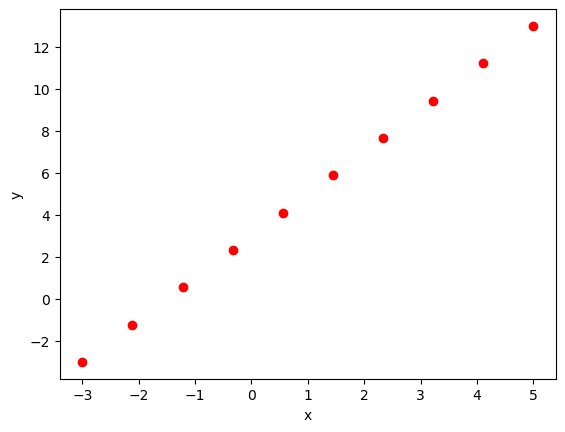

In [10]:
# plt.plot(x, y) # Това е моделът за данните
plt.scatter(x, y, color="red")  # Това са данните

plt.xlabel("x")
plt.ylabel("y")

plt.show()

Ето един дейтасет с 10 на брой точки.

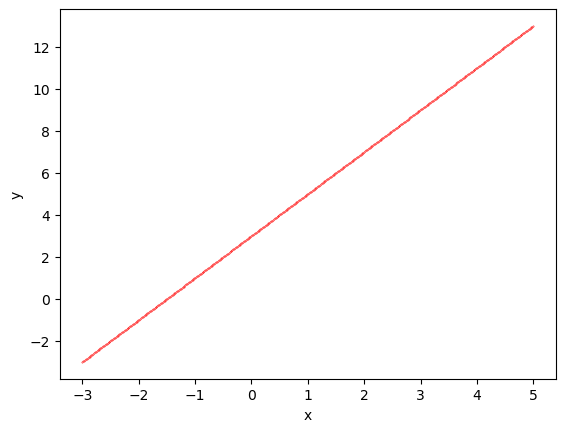

In [11]:
x = np.linspace(-3, 5, 500)
y = 2 * x + 3

plt.scatter(x, y, color="red", s = 0.1) 

plt.xlabel("x")
plt.ylabel("y")

plt.show()

Към всяка една от тези точки имаме някаква неопределеност. И тази неопределеност е една случайна променлива. Ние не се интересуваме от нея, но в случая трябва да я добавим някак си. Към нея можем да сложим всяко нещо, което не ни е интересно за модела. Казваме, че това е случаен шум. Искаме полезното нещо да го вземем, а шумът да го игнорираме. Шум е друго име за случайна променлива.

Нека създадем шум, който да добавим към плота:

In [12]:
y_noise = np.random.normal(loc = 0, scale = 1, size = len(x)) # средното на този шум ще бъде 0, стандартното отклонение ще бъде 1 и size колкото е дължината на x, за да може да направи за всяко едно

In [13]:
y_noise

array([-1.72833173e+00, -2.93430581e-02, -3.19474182e-01,  3.43664953e-01,
        9.33573398e-02,  7.46618070e-01,  2.12668869e+00,  2.20729424e+00,
       -3.04221150e-01,  2.92096744e-01,  7.29007326e-01,  1.45615113e+00,
        9.36916934e-01, -5.28669807e-01, -6.20107231e-01, -1.52994105e-01,
       -2.00604903e+00, -1.56123519e-01,  1.46975319e-01, -3.79392268e-01,
       -5.33643273e-01,  1.89496115e+00, -9.62150230e-01,  1.63012356e+00,
       -4.74073836e-01, -8.91294543e-01,  1.19507806e+00, -8.01706262e-01,
       -3.37785138e-01, -2.79119115e-01, -4.16385736e-01, -1.94428270e+00,
        2.38255463e-01,  6.08206937e-01, -4.50644286e-01,  2.28773220e+00,
        1.38717173e+00,  2.16661781e+00,  1.97244851e+00, -7.07087941e-03,
       -1.33194880e+00, -7.82193976e-01,  1.30559377e+00, -1.14025959e+00,
       -2.04474692e+00,  3.00470449e-01, -4.12667140e-01,  2.13979316e+00,
       -4.67640811e-01,  1.39463071e-02,  4.52511055e-01, -7.24712066e-01,
       -9.95426393e-02,  

In [14]:
y_result = y + y_noise

In [15]:
y_result

array([-4.72833173e+00, -2.99727893e+00, -3.25534593e+00, -2.56014266e+00,
       -2.77838615e+00, -2.09306129e+00, -6.80926542e-01, -5.68256866e-01,
       -3.04770812e+00, -2.41932610e+00, -1.95035139e+00, -1.19114346e+00,
       -1.67831353e+00, -3.11183614e+00, -3.17120944e+00, -2.67203218e+00,
       -4.49302298e+00, -2.61103334e+00, -2.27587037e+00, -2.77017383e+00,
       -2.89236071e+00, -4.31692158e-01, -3.25673941e+00, -6.32401492e-01,
       -2.70453476e+00, -3.08969134e+00, -9.71254609e-01, -2.93597480e+00,
       -2.43998955e+00, -2.34925940e+00, -2.45446189e+00, -3.95029472e+00,
       -1.73569243e+00, -1.33367683e+00, -2.36046393e+00,  4.09976687e-01,
       -4.58519651e-01,  3.52990551e-01,  1.90885381e-01, -1.75656988e+00,
       -3.04938367e+00, -2.46756472e+00, -3.47712845e-01, -2.76150207e+00,
       -3.63392527e+00, -1.25664378e+00, -1.93771724e+00,  6.46807188e-01,
       -1.92856265e+00, -1.41491141e+00, -9.44282532e-01, -2.08944153e+00,
       -1.43220797e+00, -

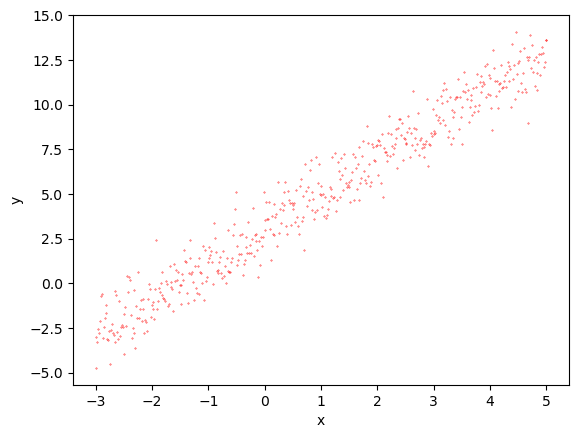

In [16]:
plt.scatter(x, y_result, color="red", s = 0.1) 

plt.xlabel("x")
plt.ylabel("y")

plt.show()

Вече виждаме как имаме облак от точки. За който облак казваме окей, интересува ни основната тенденция. Всяко друго нещо, което не я следва се счита за случайна грешка.

Искаме да намалим малко скейла:

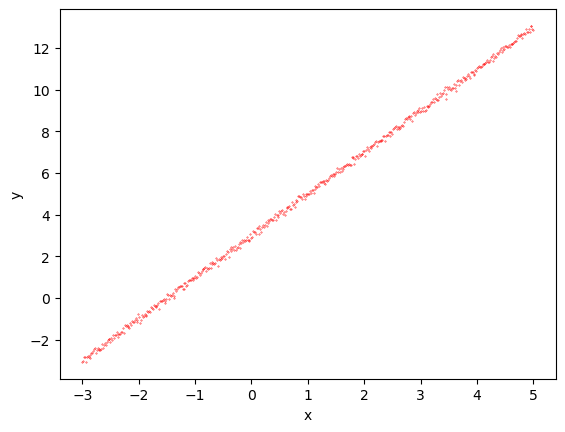

In [17]:
y_noise = np.random.normal(loc = 0, scale = 0.1, size = len(x))
y_result = y + y_noise
plt.scatter(x, y_result, color="red", s = 0.1) 

plt.xlabel("x")
plt.ylabel("y")

plt.show()

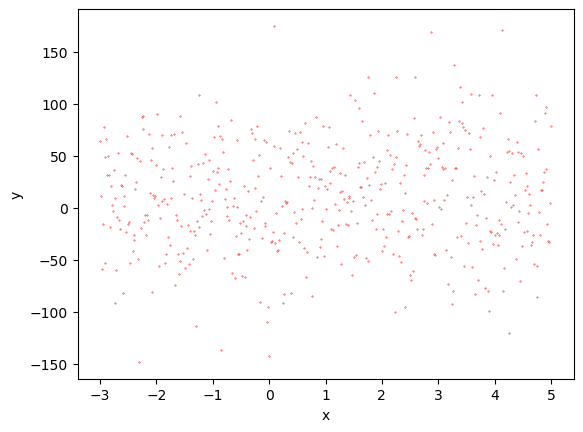

In [18]:
y_noise = np.random.normal(loc = 0, scale = 50, size = len(x))
y_result = y + y_noise

plt.scatter(x, y_result, color="red", s = 0.1) 

plt.xlabel("x")
plt.ylabel("y")

plt.show()

Тук полезната част се скри, защото шумът е повече спрямо нея.

In [19]:
y_noise = np.random.normal(loc = 0, scale = 0.7, size = len(x))
y += y_noise

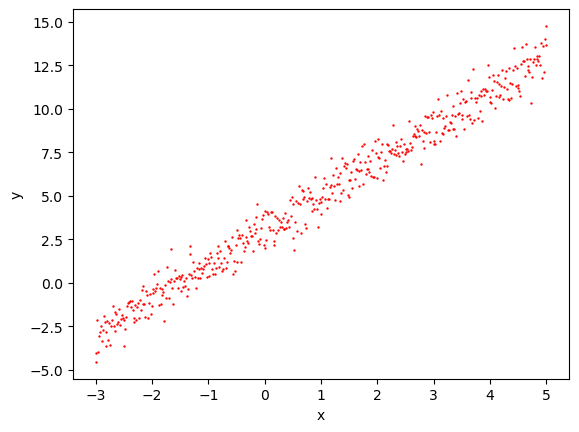

In [20]:
plt.scatter(x, y, color="red", s = 0.5) 

plt.xlabel("x")
plt.ylabel("y")

plt.show()

In [21]:
a = 8
b = 2

model_x = np.linspace(np.min(x), np.max(x), 5)
model_y = a * model_x + b  # Това е y тилда

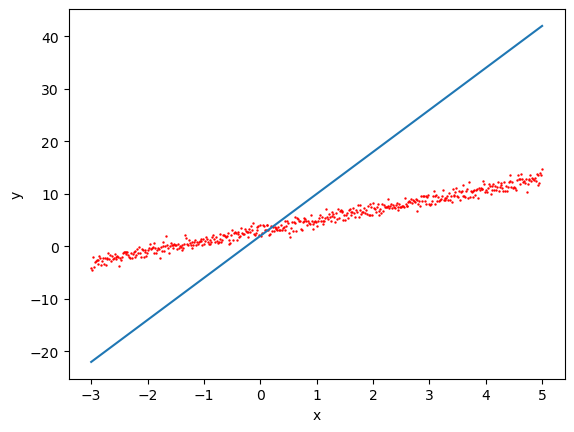

In [22]:
plt.scatter(x, y, color="red", s = 0.5) 
plt.plot(model_x, model_y)

plt.xlabel("x")
plt.ylabel("y")

plt.show()

Нека изкараме това във функция:

In [23]:
def plot_predictions(x, y, a, b):
    predictions = a * x + b
    
    plt.scatter(x, y, color="red", s = 0.5, label = "data") 
    plt.plot(x, predictions, label = "model")
    
    plt.xlabel("x")
    plt.ylabel("y")

    plt.legend()
    
    plt.show()

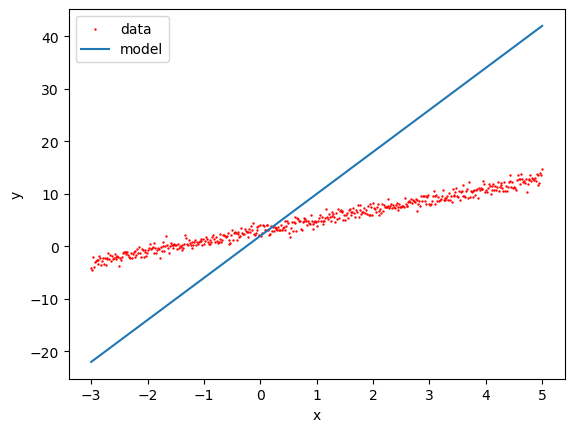

In [24]:
plot_predictions(x, y, a, b)

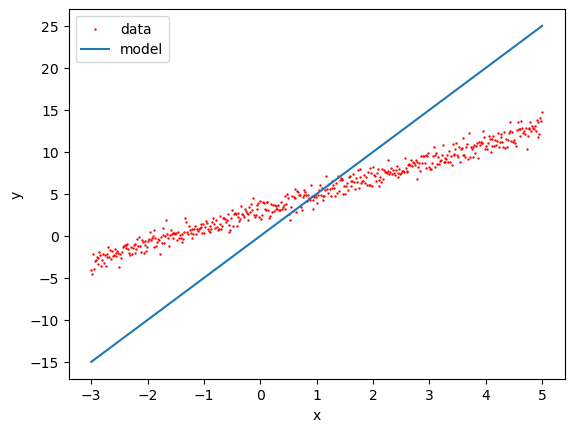

In [25]:
plot_predictions(x, y, 5, 0)

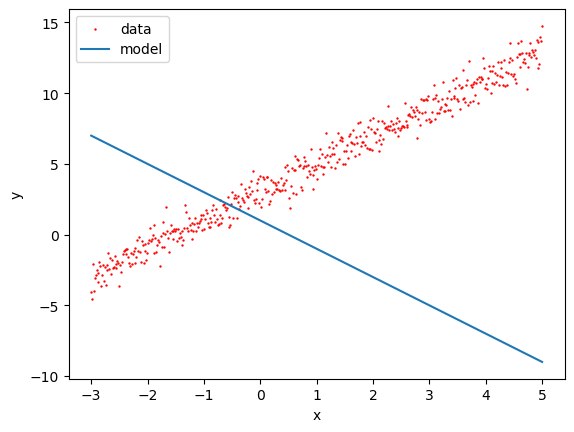

In [26]:
plot_predictions(x, y, -2, 1)

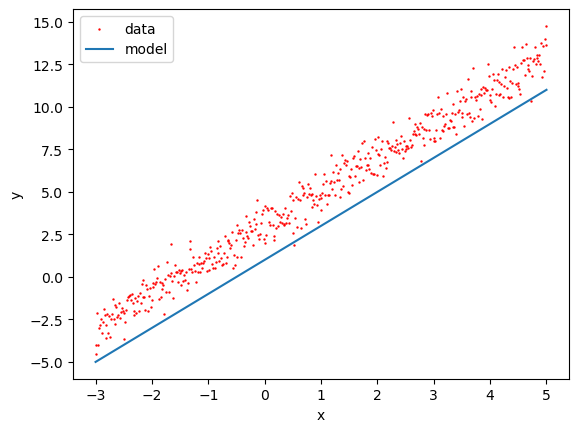

In [27]:
plot_predictions(x, y, 2, 1)

Тази е доста близо, но навсякъде подценява данните.

И вече имаме интуиция. Искам да кажа от всички възможни модели, които искам да направя аз имам представа какво представлява моя модел. Мога да му подавам различни параметри ($a$ и $b$) и ще можем да разберем кой е най-добрия от тях.
За тази работа трябва да имаме мярка колко е добър или колко моделът е подобен на данните.

__Регресия__ - не става на въпрос за намаляване, а за схождане към средното.

Като пробваме различни модели виждаме, че някои са по-добри.

Всяка една крива линия локално е права линия и можем да си я представим от много на брой много тънки малки прави линии. И пак можем да търсим разстоянието от точката, която и да е тя до съответната точка от кривата. Какво означава обаче разстояние - разстояние от точка до права е дължината на перпендикуляра от точката към правата. Защо? защото това е най-малкото разстояние. Взимаме точката, прекарваме перпендикуляра към правата и дължината на този перпендикуляра е това, което търсим.
Ортогонална регресия се нарича, когато използваме перпендикулярните разстояния.

Нека направим една функция за грешка/ функция за разстояния:

In [28]:
def compute_distances(x, y, a, b):
    predictions = a * x + b
    distances = np.abs(y - predictions)
    total_distance = np.mean(distances)
    
    # np.mean(np.abs(y - predictions)) # MAE - Mean Absolute Error
    
    return total_distance

Това са много на брой разстояния:

In [29]:
compute_distances(x, y, -2, 1)

9.147157052857501

In [30]:
compute_distances(x, y, 5, 0)

6.052587869081528

In [31]:
compute_distances(x, y, 2, 1)

2.0295020023906094

In [32]:
compute_distances(x, y, 2, 3)

0.5725754166927471

Самото число, което ще получим зависи от броя точки, които имаме. Повече точки означава по-голяма сума.

Ще говорим за производни и за оптимизация. При производните имаме проблеми понякога. Производната на една функция представлява граница и тази граница трябва да съществува и да бъде отляво и отдясно еднаква на точката.

Много повече предпочитаме да използваме гладка функция - такава, която не прави ръбове. Освен абсолютна стойност нещо друго, което не прави ръбове е на квадрат.

In [33]:
def compute_cost(x, y, a, b):
    predictions = a * x + b
    distances = (y - predictions) ** 2
    total_distance = np.mean(distances) # MSE - Mean Square Error
    
    return total_distance

Този модел за по-далечни точки ще дава по-голямо разстояние, например за 2: 4, за 3: 9, за 4: 16 и т.н. Тук по-далечните точки ще имат по-голямо влияние върху модела.

Има плюсове и минуси. Няма едно валидно решение. Нямаме нещо, което се прави "по този начин". Всяко нещо се прави по много различни начини докато си избираме този, който най-малко ни дразни 😆 .

In [34]:
compute_cost(x, y, -2, 1)

122.07014090777486

In [35]:
compute_cost(x, y, 5, 0)

49.035269470146616

In [36]:
compute_cost(x, y, 2, 1)

4.618637702961918

In [37]:
compute_cost(x, y, 2, 3)

0.5059149525554225

### Cost function (Функция на грешката)

- total cost function (обща функция на цената, която трябва да платим, за да използваме този модел)

Ще виждаме термини като __Cost function__ и __Lost function__ (функция на загуба на грешка). Като синоними Cost function е цялото нещо, Lost function е само за една точка. Т.е. Lost function ни дава първоначалния масив по-нагоре с многото стойности.

Знаем, че най-добрият модел е този, който има минимална грешка.

Ще търсим тази total_cost функция къде се минимизира. Интересува ни кога се минимизира и аргументите при които тази функция се минимизира.

$x$ и $y$ са константи. Щом са константи значи производните им са 0. Казано малко по-просто не ни интересуват. Тогава ще търсим само аргументите $a$ и $b$ при които тази функция се минимизира. За да намерим минимумите ще ни трябват частните производни спрямо $a$ и $b$

Итеративно ще използваме различни точки, за да намерим тази, която е най-близка до минимума. Този метод се наричаше
## Gradient descent

или апуакане по gradient. Метод, който се опитва да намери локален минимум "близо" до някаква начална точка.

Как правим __Gradient descent?__ <br/>
Започваме от някаква точка/някакви кординати. Тези кординати в един голям модел ще бъдат няколко милиарда.

(Всеки един моел, който можем да направим от тези данни представлява една точка от пространственост във функцията. И ние търсим коя е тази точка, която е минимална.)

gradient-a на cost функцията е просто вектор от производни.
Посоката на graient-a е там, на където функцията расте най-бързо.

In [38]:
a_gradient = -2 / len(x) * np.sum(x * (y - (a * x + b)))
b_gradient = -2 / len(y) * np.sum(y - (a * x + b))

In [39]:
def compute_gradient(x, y, a, b):
    predictions = a * x + b
    a_gradient = -2 / len(x) * np.sum(x * (y - predictions))
    b_gradient = -2 / len(y) * np.sum(y - predictions)
    return a_gradient, b_gradient

In [40]:
compute_gradient(x, y, 2, 8)

(10.055961874147457, 9.943638624796753)

In [41]:
compute_gradient(x, y, 5, 1)

(34.18421838717351, 1.9436386247967494)

In [42]:
def compute_gradient(x, y, a, b):
    predictions = a * x + b
    a_gradient = -2 / len(x) * np.sum(x * (y - predictions))
    b_gradient = -2 / len(x) * np.sum(y - predictions)
    return np.array([a_gradient, b_gradient])

In [43]:
0.01 * compute_gradient(x, y, 5, 1)

array([0.34184218, 0.01943639])

In [44]:
learning_rate = 0.01

In [45]:
a = 5
b = 1

In [46]:
compute_distances(x, y, a, b)

6.102807154979266

In [47]:
a = a - learning_rate * compute_gradient(x, y, a, b)[0]
b = b - learning_rate * compute_gradient(x, y, a, b)[1]

In [48]:
a, b

(4.658157816128265, 0.9874004574294672)

In [49]:
compute_distances(x, y, 4.371376079088153, b)

4.813967041705395

In [50]:
for step in range(1000):
    a = a - learning_rate * compute_gradient(x, y, a, b)[0]
    b = b - learning_rate * compute_gradient(x, y, a, b)[1]

In [51]:
a, b

(1.9895117598622123, 3.0386688038002467)

Това не е лош модел:

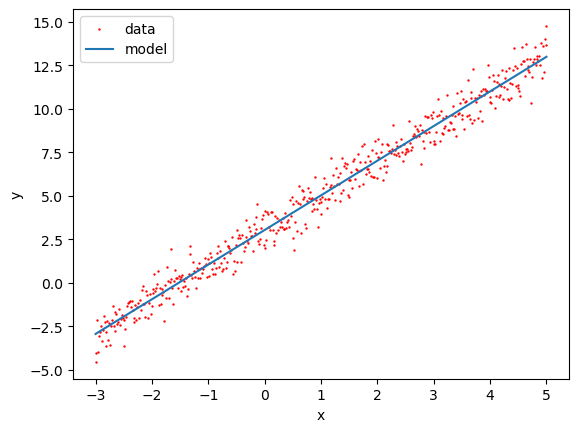

In [52]:
plot_predictions(x, y, a, b)

In [53]:
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)

LinearRegression()

In [54]:
model.coef_

array([1.98951173])

In [55]:
model.intercept_

3.038668955084034

Този модел прилича на предните, които видяхме.

In [56]:
model.predict(x.reshape(-1, 1))

array([-2.92986624e+00, -2.89797026e+00, -2.86607428e+00, -2.83417830e+00,
       -2.80228232e+00, -2.77038634e+00, -2.73849036e+00, -2.70659438e+00,
       -2.67469841e+00, -2.64280243e+00, -2.61090645e+00, -2.57901047e+00,
       -2.54711449e+00, -2.51521851e+00, -2.48332253e+00, -2.45142655e+00,
       -2.41953057e+00, -2.38763459e+00, -2.35573861e+00, -2.32384263e+00,
       -2.29194665e+00, -2.26005067e+00, -2.22815469e+00, -2.19625871e+00,
       -2.16436273e+00, -2.13246675e+00, -2.10057077e+00, -2.06867479e+00,
       -2.03677881e+00, -2.00488283e+00, -1.97298685e+00, -1.94109087e+00,
       -1.90919489e+00, -1.87729891e+00, -1.84540293e+00, -1.81350695e+00,
       -1.78161097e+00, -1.74971499e+00, -1.71781901e+00, -1.68592303e+00,
       -1.65402706e+00, -1.62213108e+00, -1.59023510e+00, -1.55833912e+00,
       -1.52644314e+00, -1.49454716e+00, -1.46265118e+00, -1.43075520e+00,
       -1.39885922e+00, -1.36696324e+00, -1.33506726e+00, -1.30317128e+00,
       -1.27127530e+00, -

Това е най-важното в Машийн лърнинг - моделиране на данни:
- предположения
- модел
- оценка на този модел
- резултат
- подобряване

Сега ще направим класификация на 2 класа - клас 0 и клас 1. 

### Логистична функция (Logistic Regression)

In [57]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [58]:
y = sigmoid(a * x + b)

In [59]:
x = np.linspace(-5, 5, 20)
y = (x >= 3).astype(int)

In [60]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [61]:
y_noise = np.random.normal(0, 0.1, len(x))

In [62]:
classification_model = LogisticRegression()

In [63]:
classification_model.fit(x.reshape(-1, 1), y)

LogisticRegression()

In [64]:
classification_model.predict(x.reshape(-1, 1))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

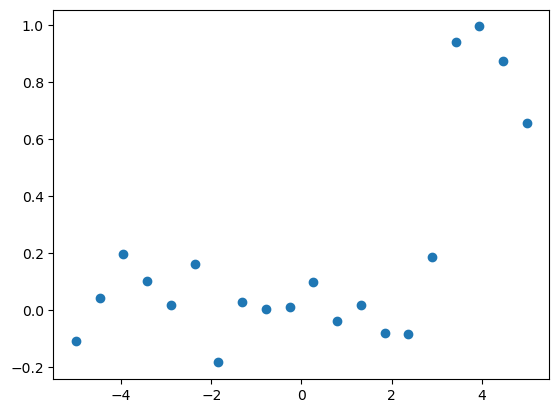

In [65]:
plt.scatter(x, y + y_noise)

In [66]:
classification_model.coef_

array([[1.40495051]])

In [67]:
classification_model.intercept_

array([-4.48884031])

In [68]:
classification_model.predict_proba(x.reshape(-1, 1))

array([[9.99990007e-01, 9.99322839e-06],
       [9.99979067e-01, 2.09333671e-05],
       [9.99956150e-01, 4.38497545e-05],
       [9.99908149e-01, 9.18510967e-05],
       [9.99807612e-01, 1.92388321e-04],
       [9.99597074e-01, 4.02925981e-04],
       [9.99156332e-01, 8.43668373e-04],
       [9.98234333e-01, 1.76566722e-03],
       [9.96308455e-01, 3.69154525e-03],
       [9.92298158e-01, 7.70184181e-03],
       [9.84001249e-01, 1.59987513e-02],
       [9.67063059e-01, 3.29369409e-02],
       [9.33405716e-01, 6.65942835e-02],
       [8.69979055e-01, 1.30020945e-01],
       [7.61573562e-01, 2.38426438e-01],
       [6.03932624e-01, 3.96067376e-01],
       [4.21268234e-01, 5.78731766e-01],
       [2.57879928e-01, 7.42120072e-01],
       [1.42281971e-01, 8.57718029e-01],
       [7.33786330e-02, 9.26621367e-01]])

In [69]:
predictions = classification_model.predict_proba(x.reshape(-1, 1))

In [70]:
np.argmax(predictions, axis = 0)

array([ 0, 19], dtype=int64)

In [71]:
np.argmax(predictions, axis = 1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
      dtype=int64)